# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Definovanie pomocných funkcií

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Transformacia kategorických údajov na numerické

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")
from sklearn import preprocessing
from sklearn import linear_model
import datetime as dt

from fancyimpute import KNN

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 12, 9
from IPython.display import Image

#Integracia
from scipy.stats import boxcox
import scipy.stats as stats

/Users/peterjurkacek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Definovanie pomocných funkcií

In [2]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [3]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    # Pomenujeme si index
    data.index.name = 'ID'
    # Ujednoti format nazvov stlpcov
    data = data.rename(columns=fixWierdCharsInString)
    print("Index name", data.index.name)
    print(data.columns)
    return data

In [4]:
file_cleaned_train_data = 'data/zadanie4/clean_train.csv'
file_cleaned_test_data = 'data/zadanie4/clean_test.csv'
file = 'data/zadanie4/clean_categorical_test.csv'

In [5]:
def create_csv(df, file_name):
    df.to_csv(file_name, sep=',')

In [6]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(data.name, z, pval, True if pval > 0.05 else False)
    if(pval < 0.05):
        return print("Not normal distribution")

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [7]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [8]:
def checkAllNumericType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    numeric_data = data.select_dtypes(['int64','float64'])
    for col_name in numeric_data.columns:
        #Spočítame si pre každý "Numerický" atribút počet jeho jedinečných hodnôt
        print(col_name,": modus:",numeric_data[col_name].mode(),", mean:", numeric_data[col_name].describe())
    numeric_data.apply(isNormalDistribution)

In [9]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            print(string)
            return pd.NaT

In [10]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    return forloop

In [11]:
def calculateAgeFromDate(data, start_date):
    date = pd.to_datetime(start_date)
    data.loc[data[age_column].isna() & data[date_column].notna(), age_column] = (date - data.loc[(data[age_column].isna() & data[date_column].notna()), date_column]).astype('int64') 

In [12]:
def calculateDateFromAge(row):
    date = pd.to_datetime('2016-01-01')
    result_date = date.year - row['AGE']
    row['DATE_OF_BIRTH'] = pd.to_datetime(str(int(result_date)), errors='coerce')
    return row

In [13]:
def getFemaleSymbol():
    return 'FEMALE'

In [14]:
def getMaleSymbol():
    return 'MALE'

In [15]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [16]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [17]:
def prop_complete(data):
    return 1 - prop_missing(data)

# Dataset

In [18]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/test.csv"
test_data = init_dataset(test_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [19]:
train_file = "data/zadanie4/train.csv"
train_data = init_dataset(train_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [20]:
#Aby sme mohli pracovat 
train = False
if train:
    data = train_data
else:
    data = test_data

file_median_train = 'data/clean_train_data/ctrain_median.csv'
file_modus_train = 'data/clean_train_data/ctrain_modus.csv'
file_mean_train = 'data/clean_train_data/ctrain_mean.csv'
file_knn_train = 'data/clean_train_data/ctrain_knn.csv'

file_median_test = 'data/clean_test_data/ctest_median.csv'
file_modus_test = 'data/clean_test_data/ctest_modus.csv'
file_mean_test = 'data/clean_test_data/ctest_mean.csv'
file_knn_test = 'data/clean_test_data/ctest_knn.csv'

# Zjednotenie formátov a typov dát

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 39 columns):
AGE                          972 non-null int64
SEX                          972 non-null object
ON_THYROXINE                 972 non-null object
QUERY_ON_THYROXINE           972 non-null object
ON_ANTITHYROID_MEDICATION    972 non-null object
SICK                         972 non-null object
PREGNANT                     972 non-null object
THYROID_SURGERY              972 non-null object
I131_TREATMENT               972 non-null object
QUERY_HYPOTHYROID            972 non-null object
QUERY_HYPERTHYROID           972 non-null object
LITHIUM                      972 non-null object
GOITRE                       972 non-null object
TUMOR                        972 non-null object
HYPOPITUITARY                972 non-null object
PSYCH                        972 non-null object
TSH_MEASURED                 972 non-null object
TSH                          887 non-null float64
T3_MEASURED  

In [22]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 1
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 162
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 972
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 866
PERSONAL_INFO : 338


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [23]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    882.000000
mean     109.565533
std       33.669539
min        2.800000
25%       92.000000
50%      106.000000
75%      124.000000
max      291.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 

In [24]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')

data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], [getFemaleSymbol(), getMaleSymbol()], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

FEMALE    650
MALE      282
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [25]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)

In [26]:
checkAllObjectType(data)

SEX : 2
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 972
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 866
PERSONAL_INFO : 338


In [27]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     274
 Husband           186
 Unmarried         175
 Own-child         152
 Wife               98
 Other-relative     37
 Not_in_family      24
 Own_child          20
 Other_relative      6
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [28]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     298
HUSBAND           186
UNMARRIED         175
OWN_CHILD         172
WIFE               98
OTHER_RELATIVE     43
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [29]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

1991-08-07
1963-05-03
1989-02-15
1983-01-28
1957-09-10
1955-09-24
1992-05-30
1992-04-30
1962-06-23
1978-06-22
1980-05-04
1961-06-13
1954-04-01
1948-01-30
1980-04-02
1943-05-09
1946-12-21
1946-09-07
1971-10-26
1934-08-30
1990-05-18
1950-05-12
1957-12-18
1944-07-08
1961-12-16
1956-03-26
1962-01-18
1963-03-02
1957-02-28
1989-11-30
1958-01-21
1997-01-10
1968-12-25
1988-08-11
1959-04-22
1989-05-12
1991-05-07
1948-05-23
1998-09-07
1998-11-28
1940-02-01
1942-05-27
1966-10-15
1951-10-07
1959-11-06
1948-11-13
1965-09-08
1961-04-26
02-11-16
1979-05-21
1958-01-17
1975-07-31
1988-03-28
1984-12-22
1954-04-30
1982-03-06
1986-11-03
1984-05-05
1958-06-26
1952-12-07
1981-10-30
1952-07-09
1952-05-19


count                     875
unique                    850
top       1967-09-30 00:00:00
freq                        2
first     1924-10-04 00:00:00
last      2010-05-07 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 971
Data columns (total 39 columns):
AGE                          972 non-null int64
SEX                          932 non-null object
ON_THYROXINE                 972 non-null bool
QUERY_ON_THYROXINE           972 non-null bool
ON_ANTITHYROID_MEDICATION    972 non-null bool
SICK                         972 non-null bool
PREGNANT                     972 non-null bool
THYROID_SURGERY              972 non-null bool
I131_TREATMENT               972 non-null bool
QUERY_HYPOTHYROID            972 non-null bool
QUERY_HYPERTHYROID           972 non-null bool
LITHIUM                      972 non-null bool
GOITRE                       972 non-null bool
TUMOR                        972 non-null bool
HYPOPITUITARY                972 non-null bool
PSYCH                        972 non-null bool
TSH_MEASURED                 972 non-null bool
TSH                          887 non-null float64
T3_MEASURED                  972 non-null b

In [31]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Sales,United-States,Married-civ-spouse,Self-emp-inc,White
1,Exec-managerial,United-States,Never-married,Private,White
2,Prof-specialty,United-States,Married-civ-spouse,Self-emp-not-inc,White
3,Tech-support,United-States,Married-civ-spouse,Private,White
4,Other-service,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [32]:
checkAllObjectType(test_data)

SEX : 2
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 972
EDUCATION : 16
RELATIONSHIP : 6
PERSONAL_INFO : 338


In [33]:
fixWierdCharsInObjectType(df_personal_data)

{'JOB': {'ADM_CLERICAL': 0.16294642857142858,
  'CRAFT_REPAIR': 0.07700892857142858,
  'EXEC_MANAGERIAL': 0.125,
  'FARMING_FISHING': 0.014508928571428572,
  'HANDLERS_CLEANERS': 0.018973214285714284,
  'MACHINE_OP_INSPCT': 0.06473214285714286,
  'OTHER_SERVICE': 0.16741071428571427,
  'PRIV_HOUSE_SERV': 0.014508928571428572,
  'PROF_SPECIALTY': 0.13504464285714285,
  'PROTECTIVE_SERV': 0.011160714285714286,
  'SALES': 0.14508928571428573,
  'TECH_SUPPORT': 0.03571428571428571,
  'TRANSPORT_MOVING': 0.027901785714285716},
 'JOB_SEGMENT': {'?': 0.07818930041152264,
  'FEDERAL_GOV': 0.01954732510288066,
  'LOCAL_GOV': 0.06790123456790123,
  'PRIVATE': 0.7067901234567902,
  'SELF_EMP_INC': 0.01954732510288066,
  'SELF_EMP_NOT_INC': 0.059670781893004114,
  'STATE_GOV': 0.04835390946502058},
 'MARITAL_STATUS': {'DIVORCED': 0.19135802469135801,
  'MARRIED_AF_SPOUSE': 0.00102880658436214,
  'MARRIED_CIV_SPOUSE': 0.29732510288065844,
  'MARRIED_SPOUSE_ABSENT': 0.01646090534979424,
  'NEVER_MAR

Vidíme, že hodnôt pre štát je príliš vela a pritom 90 percent pacientov je zo spojených štátov. Preto zredukujeme kategorické atribúty pre štát nasledovne

In [34]:
df_personal_data['STATE'] = [ 'UNITED_STATES' if x == 'UNITED_STATES' else 'OTHER' for x in df_personal_data['STATE']]

In [35]:
df_personal_data['STATE'].value_counts()

UNITED_STATES    874
OTHER             98
Name: STATE, dtype: int64

Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [36]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [37]:
column = fixWierdCharsInString('class')
data[column].head()

ID
0    negative.|1231
1     negative.|329
2    negative.|2518
3     negative.|821
4     negative.|951
Name: CLASS, dtype: object

In [38]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               935
underreplacement        17
overreplacement         11
replacement therapy      9
Name: CLASS, dtype: int64

In [39]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               935
underreplacement        17
overreplacement         11
replacement therapy      9
Name: CLASS, dtype: int64

In [40]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     301
10.0    227
13.0    159
14.0     54
11.0     47
7.0      44
6.0      31
12.0     29
5.0      20
8.0      17
4.0      14
15.0     11
16.0      7
3.0       6
1.0       3
2.0       2
Name: EDUCATION_NUM, dtype: int64

In [41]:
data = data.drop(columns=['EDUCATION'])

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [42]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [43]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [44]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

SEX : 2
REFERRAL_SOURCE : 5
RELATIONSHIP : 6
JOB : 13
STATE : 2
MARITAL_STATUS : 7
JOB_SEGMENT : 6
RACE : 5
CLASS : 4


,SEX,REFERRAL_SOURCE,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,
0,MALE,SVI,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_INC,WHITE,NEGATIVE
1,FEMALE,SVHC,NOT_IN_FAMILY,EXEC_MANAGERIAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,NEGATIVE
2,FEMALE,OTHER,WIFE,PROF_SPECIALTY,UNITED_STATES,MARRIED_CIV_SPOUSE,SELF_EMP_NOT_INC,WHITE,NEGATIVE
3,FEMALE,SVHC,WIFE,TECH_SUPPORT,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
4,FEMALE,OTHER,UNMARRIED,OTHER_SERVICE,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,NEGATIVE


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Chýbajúce hodnoty

In [45]:
import missingno as msno

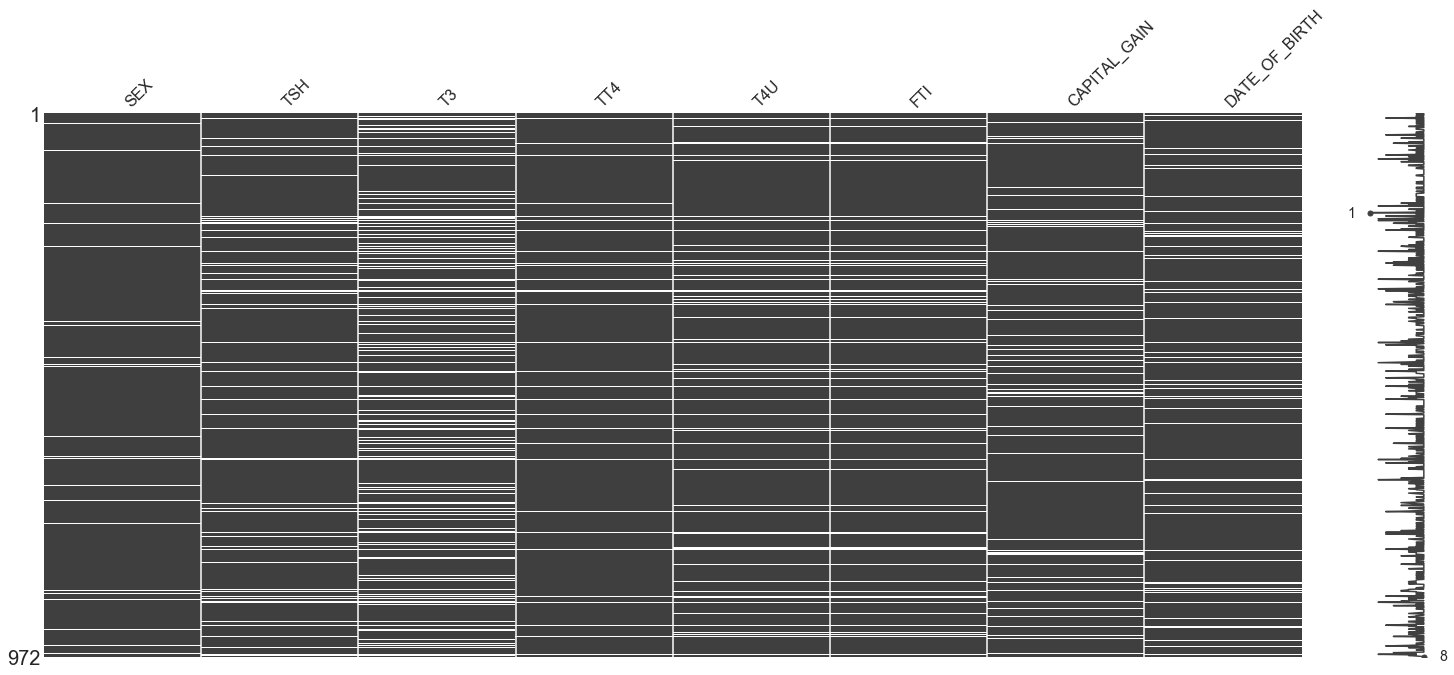

In [46]:
test_data.columns[test_data.isnull().any()].tolist()
msno.matrix(test_data[test_data.columns[test_data.isnull().any()].tolist()])

In [47]:
checkpoint_missing_data = data.copy()

Počty chýbajúcich hodnôt v jednotlivých atribútoch.http://scikit-learn.org/stable/data_transforms.html

In [48]:
data.apply(count_missing)

AGE                            0
SEX                           40
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                           85
T3_MEASURED                    0
T3                           184
TT4_MEASURED                   0
TT4                           47
T4U_MEASURED                   0
T4U                           90
FTI_MEASURED                   0
FTI                           90
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION_NUM                  0
RELATIONSHIP                   0
CAPITAL_GA

In [49]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

0    530
1    235
2    107
3     36
5     24
4     22
6     13
8      2
7      2
9      1
dtype: int64

In [50]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

(972, 40)

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [51]:
data['SEX'].isna().sum()

40

In [52]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = getFemaleSymbol()
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [53]:
data['SEX'].isna().sum()

39

In [54]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = getFemaleSymbol()
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = getMaleSymbol()

In [55]:
data['SEX'].isna().sum()

17

In [56]:
# Vyfiltrujeme si pacientov s nešpecifikovaným datumom narodenia, a doplnime ich podla veku za predpokladu ze dataset bol robeni v roku 2016.
column = fixWierdCharsInString('date_of_birth')
help_column = fixWierdCharsInString('age')
data.loc[(data[column].isna()) & (data[help_column].notna()),[column, help_column]] = data.loc[(data[column].isna()) & (data[help_column].notna()),[column, help_column]].apply(calculateDateFromAge, axis=1)

In [57]:
data['DATE_OF_BIRTH'].isna().sum()

0

## Doplnenie chýbajúcich hodnôt po stĺpcoch

In [58]:
if train:
    create_csv(data,file_median_train)
    create_csv(data,file_modus_train) 
    create_csv(data,file_mean_train)
    create_csv(data,file_knn_train)
else:
    create_csv(data,file_median_test)
    create_csv(data,file_modus_test)
    create_csv(data,file_mean_test)
    create_csv(data,file_knn_test)

In [59]:
checkpoint_missing_data_by_columns = data.copy()

### Vytvorenie imputerov

In [60]:
imp_most_frequent = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_median = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)

In [61]:
checkAllObjectType(data)

SEX : 2
REFERRAL_SOURCE : 5
RELATIONSHIP : 6
JOB : 13
STATE : 2
MARITAL_STATUS : 7
JOB_SEGMENT : 6
RACE : 5
CLASS : 4


Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [62]:
#Doplnime vsetky numericke pomocou imputer
#col_names = data.select_dtypes(exclude=['object', 'datetime64']).columns
#data.loc[:,col_names] = pd.DataFrame(imp_most_frequent.fit_transform(filled_numeric_data), columns=col_names)

In [63]:
data.apply(count_missing)

AGE                            0
SEX                           17
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                           85
T3_MEASURED                    0
T3                           184
TT4_MEASURED                   0
TT4                           47
T4U_MEASURED                   0
T4U                           90
FTI_MEASURED                   0
FTI                           90
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION_NUM                  0
RELATIONSHIP                   0
CAPITAL_GA

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [64]:
column = fixWierdCharsInString('job')
data[column].isnull().sum()

76

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [65]:
#column = fixWierdCharsInString('state')
#count_missing(data[column])

In [66]:
#mode = data[column].mode()
#data[column].fillna(mode[0], inplace=True)

In [67]:
count_missing(data[column])

76

In [68]:
data['JOB_SEGMENT'].value_counts()

PRIVATE             687
LOCAL_GOV            66
SELF_EMP_NOT_INC     58
STATE_GOV            47
SELF_EMP_INC         19
FEDERAL_GOV          19
Name: JOB_SEGMENT, dtype: int64

Chýbajúce hodnoty v atribúte **JOB_SEGMENT** sme doplnili pomocou najčastejšie sa vyskytujúcej hodnoty.

In [69]:
column = fixWierdCharsInString('job_segment')
mode = data[column].mode()
#data[column].fillna(mode[0], inplace=True)

In [70]:
count_missing(data[column])

76

In [71]:
if not train:
    clean_data = init_dataset('data/clean_train_data/clean_train.csv')
else:
    create_csv(data,'data/clean_train_data/clean_train.csv')
    clean_data = data
    
    

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'REFERRAL_SOURCE', 'FNLWGT', 'EDUCATION_NUM',
       'RELATIONSHIP', 'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK',
       'DATE_OF_BIRTH', 'JOB', 'STATE', 'MARITAL_STATUS', 'JOB_SEGMENT',
       'RACE', 'CLASS'],
      dtype='object')


In [72]:
data.select_dtypes(include=['int', 'float']).describe()


,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
count,972.000000,887.000000,788.000000,925.000000,882.000000,882.000000,972.000000,972.000000,875.000000,972.000000,972.000000
mean,51.423868,6.262835,1.981269,106.189622,0.986735,109.565533,185453.675926,10.036008,724.384000,49.802469,38.554527
std,18.966700,31.638353,0.835031,36.130949,0.198332,33.669539,102382.137299,2.467866,5322.514084,301.966019,13.694929
min,7.000000,0.005000,0.200000,2.900000,0.250000,2.800000,21755.000000,1.000000,0.000000,0.000000,1.000000
25%,35.000000,0.515000,1.500000,87.000000,0.870000,92.000000,115750.500000,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.300000,2.000000,103.000000,0.970000,106.000000,175291.500000,10.000000,0.000000,0.000000,40.000000
75%,67.000000,2.900000,2.300000,123.000000,1.080000,124.000000,227778.750000,12.000000,0.000000,0.000000,40.000000
max,93.000000,530.000000,8.500000,372.000000,2.320000,291.000000,858091.000000,16.000000,99999.000000,2444.000000,99.000000


In [86]:
clean_data.loc[:, columns].mode().loc[:3]

,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
0,59.0,0.2,2.0,101.0,0.99,100.0,32616,9.0,0.0,0.0,40.0
1,NaN,NaN,NaN,NaN,NaN,107.0,37618,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,74883,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,80680,NaN,NaN,NaN,NaN


In [85]:
clean_data.loc[:, columns].mean()

AGE                   51.844230
TSH                    4.672150
T3                     2.024966
TT4                  109.072401
T4U                    0.997912
FTI                  110.787984
FNLWGT            187123.102143
EDUCATION_NUM         10.048214
CAPITAL_GAIN         881.830952
CAPITAL_LOSS          65.141786
HOURS_PER_WEEK        38.544643
dtype: float64

In [73]:
# Doplnenie podla priemeru
imputed_DF = data.copy()
columns = clean_data.select_dtypes(include=['int', 'float']).columns
imputed_DF.fillna(clean_data.loc[:, columns].mean(), inplace=True)

if train:
    create_csv(imputed_DF, file_mean_train)
else:
    create_csv(imputed_DF, file_mean_test)

imputed_DF.shape

(972, 40)

In [74]:
imputed_DF.describe()

,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
count,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,51.423868,6.123732,1.989541,106.329015,0.987770,109.678723,185453.675926,10.036008,740.096299,49.802469,38.554527
std,18.966700,30.225198,0.751957,35.251097,0.188945,32.073182,102382.137299,2.467866,5049.889836,301.966019,13.694929
min,7.000000,0.005000,0.200000,2.900000,0.250000,2.800000,21755.000000,1.000000,0.000000,0.000000,1.000000
25%,35.000000,0.600000,1.675000,87.000000,0.880000,93.750000,115750.500000,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.550000,2.024966,104.000000,0.990000,110.000000,175291.500000,10.000000,0.000000,0.000000,40.000000
75%,67.000000,3.900000,2.200000,121.250000,1.060000,121.000000,227778.750000,12.000000,0.000000,0.000000,40.000000
max,93.000000,530.000000,8.500000,372.000000,2.320000,291.000000,858091.000000,16.000000,99999.000000,2444.000000,99.000000


In [75]:
# Doplnenie podla medianu
fill_NaN = preprocessing.Imputer(missing_values=np.nan, strategy='median', axis=1)
fill_NaN.fit(clean_data.select_dtypes(include=['int', 'float']))

imputed_DF = pd.DataFrame(fill_NaN.transform(data.select_dtypes(include=['int', 'float'])))
imputed_DF.columns = clean_data.select_dtypes(include=['int', 'float']).columns
imputed_DF.index = data.select_dtypes(include=['int', 'float']).index

imputed_DF = imputed_DF.join(clean_data.select_dtypes(exclude=['int', 'float']))

if train:
    create_csv(imputed_DF, file_median_train)
else:
    create_csv(imputed_DF, file_median_test)
    
imputed_DF.shape

(972, 40)

In [76]:
imputed_DF.describe()

,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
count,972.000000,972.00000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,51.423868,8.17483,6.712181,102.228035,2.667747,101.192953,185453.675926,10.036008,654.657253,49.802469,38.554527
std,18.966700,31.04962,11.237838,39.476229,6.441280,41.593086,102382.137299,2.467866,5054.015595,301.966019,13.694929
min,7.000000,0.00500,0.200000,2.900000,0.250000,2.800000,21755.000000,1.000000,0.000000,0.000000,1.000000
25%,35.000000,0.60000,1.675000,83.000000,0.880000,86.750000,115750.500000,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.55000,2.100000,101.000000,0.990000,104.000000,175291.500000,10.000000,0.000000,0.000000,40.000000
75%,67.000000,3.90000,2.900000,121.250000,1.130000,121.000000,227778.750000,12.000000,0.000000,0.000000,40.000000
max,93.000000,530.00000,88.000000,372.000000,60.000000,291.000000,858091.000000,16.000000,99999.000000,2444.000000,99.000000


In [77]:
# Doplnenie podla most frequent
imputed_DF = data.copy()
columns = clean_data.select_dtypes(include=['int', 'float']).columns
imputed_DF.fillna(clean_data.loc[:, columns].mode().loc[0], inplace=True)

if train:
    create_csv(imputed_DF, file_modus_train)
else:
    create_csv(imputed_DF, file_modus_test)

imputed_DF.shape

(972, 40)

In [78]:
imputed_DF.describe()

,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
count,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,51.423868,5.732649,1.984815,105.938683,0.987037,108.679835,185453.675926,10.036008,652.094650,49.802469,38.554527
std,18.966700,30.270396,0.751798,35.263262,0.188919,32.190976,102382.137299,2.467866,5054.339337,301.966019,13.694929
min,7.000000,0.005000,0.200000,2.900000,0.250000,2.800000,21755.000000,1.000000,0.000000,0.000000,1.000000
25%,35.000000,0.275000,1.675000,87.000000,0.880000,93.750000,115750.500000,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.200000,2.000000,101.000000,0.990000,104.000000,175291.500000,10.000000,0.000000,0.000000,40.000000
75%,67.000000,2.700000,2.200000,121.250000,1.060000,121.000000,227778.750000,12.000000,0.000000,0.000000,40.000000
max,93.000000,530.000000,8.500000,372.000000,2.320000,291.000000,858091.000000,16.000000,99999.000000,2444.000000,99.000000


In [79]:


X_filled_knn = pd.DataFrame(KNN(k=3).complete(data.select_dtypes(include=['int', 'float'])), columns=data.select_dtypes(include=['int', 'float']).columns)

X_filled_knn = X_filled_knn.join(data.select_dtypes(exclude=['int', 'float']))

if train:
    create_csv(X_filled_knn, file_knn_train)
else:
    create_csv(X_filled_knn, file_knn_test)

Imputing row 1/972 with 0 missing, elapsed time: 0.173
Imputing row 101/972 with 0 missing, elapsed time: 0.175
Imputing row 201/972 with 0 missing, elapsed time: 0.176
Imputing row 301/972 with 1 missing, elapsed time: 0.178
Imputing row 401/972 with 0 missing, elapsed time: 0.179
Imputing row 501/972 with 0 missing, elapsed time: 0.181
Imputing row 601/972 with 2 missing, elapsed time: 0.182
Imputing row 701/972 with 0 missing, elapsed time: 0.184
Imputing row 801/972 with 0 missing, elapsed time: 0.185
Imputing row 901/972 with 2 missing, elapsed time: 0.187


In [80]:
X_filled_knn.describe()

,AGE,TSH,T3,TT4,T4U,FTI,FNLWGT,EDUCATION_NUM,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK
count,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000
mean,51.423868,6.754821,1.963476,105.965692,0.988326,109.095884,185453.675926,10.036008,797.133128,49.802469,38.554527
std,18.966700,32.179904,0.785375,35.796790,0.193546,33.101597,102382.137299,2.467866,5942.529154,301.966019,13.694929
min,7.000000,0.005000,0.200000,2.900000,0.250000,2.800000,21755.000000,1.000000,0.000000,0.000000,1.000000
25%,35.000000,0.598348,1.500000,87.000000,0.870000,92.000000,115750.500000,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.400000,1.943106,102.985330,0.970000,106.000000,175291.500000,10.000000,0.000000,0.000000,40.000000
75%,67.000000,3.000000,2.300000,122.000000,1.080000,124.000000,227778.750000,12.000000,0.000000,0.000000,40.000000
max,93.000000,530.000000,8.500000,372.000000,2.320000,291.000000,858091.000000,16.000000,99999.000000,2444.000000,99.000000


In [81]:
X_filled_knn.shape

(972, 40)

In [82]:
imputed_DF.apply(count_missing)

AGE                           0
SEX                          17
ON_THYROXINE                  0
QUERY_ON_THYROXINE            0
ON_ANTITHYROID_MEDICATION     0
SICK                          0
PREGNANT                      0
THYROID_SURGERY               0
I131_TREATMENT                0
QUERY_HYPOTHYROID             0
QUERY_HYPERTHYROID            0
LITHIUM                       0
GOITRE                        0
TUMOR                         0
HYPOPITUITARY                 0
PSYCH                         0
TSH_MEASURED                  0
TSH                           0
T3_MEASURED                   0
T3                            0
TT4_MEASURED                  0
TT4                           0
T4U_MEASURED                  0
T4U                           0
FTI_MEASURED                  0
FTI                           0
REFERRAL_SOURCE               0
FNLWGT                        0
EDUCATION_NUM                 0
RELATIONSHIP                  0
CAPITAL_GAIN                  0
CAPITAL_

## TSH, T3, TT4, T4U, FTI

V týchto atribúte budeme dopĺňať chýbajúce hodnoty pomocou stratégie modus (most_frequent) a lineárnej regresie. Tieto dve stratégie potom porovnáme. 

In [83]:
col_names = = ['TSH', 'T4U', 'T3', 'TT4', 'FTI']
#Natrenovanie
imp_most_frequent = imp_most_frequent.fit(data.loc[:, [col]])
#Doplnenie
for col in col_names:
     data[col] = pd.DataFrame(imp_most_frequent.transform(data.loc[:, [col]]))

SyntaxError: invalid syntax (<ipython-input-83-10b95fe42914>, line 1)

In [ ]:
test_data.apply(count_missing)

### Metóda k najbližších susedov

In [ ]:
##data = checkpoint_missing_data_by_columns.copy()
col_names = ['TSH', 'T4U', 'T3', 'TT4', 'FTI']
if count_missing(data[col_names]).sum() > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(data[col_names]), columns=col_names)
    #Prirad pomocou KNN
    for col in col_names:
        data[col] = X_filled_knn[col]

In [ ]:
if count_missing(test_data[col_names]).sum() > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(test_data[col_names]), columns=col_names)
    #Prirad pomocou KNN
    for col in col_names:
        test_data[col] = X_filled_knn[col]

In [ ]:
data['SEX'].describe()

In [ ]:
if count_missing(data['SEX']) > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(data[['SEX']]), columns=['SEX'])
    data['SEX'] = X_filled_knn['SEX']

In [ ]:
if count_missing(test_data['SEX']) > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(test_data[['SEX']]), columns=['SEX'])
    test_data['SEX'] = X_filled_knn['SEX']

In [ ]:
test_data.apply(count_missing)

In [ ]:
test_data['JOB'].isnull().sum()

Kedže nám ostali dve neznáme hodnoty pre Vek a Dátum narodenia môžeme ich odstrániť alebo dopočítať ale zbytočne si môžeme zaniesť zlé dáta. Kedže sa jedná len o dvoch pacientov tak sme sa ich rozhodli odstrániť

In [ ]:
data = data[data['DATE_OF_BIRTH'].notna()]

In [ ]:
data.apply(count_missing)

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

In [ ]:
#vychylene_hodnoty_checkpoint = data.copy()

In [ ]:
data.select_dtypes(exclude=['bool', 'object']).hist(figsize=(18, 12))

Vidíme že TSH nie je normálne rozdelenie a preto ho bude treba znormalizovat

In [ ]:
column = fixWierdCharsInString('TSH')
data_for_plot = pd.DataFrame(data[column], columns=[column])
transformed, att = boxcox(data_for_plot[column])# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
data_for_plot['BOXCOX_NORM'] = pd.DataFrame(transformed)

#pom = pd.Series(data_for_plot).hist(bins=50)
#pom.set_title("index: TSH")

In [ ]:
data_for_plot.hist()

In [ ]:
data_for_plot['BOXCOX_NORM'].plot.box()

Atribút **age** odstránenie odchýlených hodnôt.

In [ ]:
data['AGE'].plot(kind="box")

Táto vychýlená hodnota vznikla pravdepodobne nesprávne odmeranými alebo vyplnenými údajmi. Skutočný vek tohto pacienta mohol byť napríklad 45 rokov, ale aj 55 rokov, no nevieme to zistiť tak sme sa rozhodli nahradiť hodnotu mediánom. 

In [ ]:
column = fixWierdCharsInString('age')
data.loc[(data[column] < 1) | (data[column] > 100), [column]] = data[column].median()
data['AGE'].plot(kind="box")

In [ ]:
column = fixWierdCharsInString('age')
test_data.loc[(test_data[column] < 1) | (test_data[column] > 100), [column]] = test_data[column].median()
test_data['AGE'].plot(kind="box")

Ako iný spôsob odstránenia tejto vychýlenej hodnoty by sme mohli použiť nahradenie hornej vychýlenej hodnoty 95 percentilom a dolnej vychýlenej hodnoty 5 kvantilom. Takisto by sme mohli použiť aj metódu nahradenia medianom, pretože tento vek sa mohol pohybovať okolo 45, 55 rokov a to je približne median.

In [ ]:
#data.loc[(data[column] > 100), column] = data[column].quantile(0.95) 
#data.loc[(data[column] < 1), column] = data[column].quantile(0.05)
data['AGE'].mode()
data.info()

In [ ]:
col_names = ['TSH','T4U', 'T3', 'TT4', 'FTI']
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
data.loc[:,col_names].plot.box(color=color, sym='r+')

In [ ]:
col_names = ['TSH','T4U', 'T3', 'TT4', 'FTI', 'CLASS']
df_box = data.loc[:,col_names]
bp = df_box.boxplot(by='CLASS')

# Manuálne podmienky vyhodnocovania

In [ ]:
seaborn.set_style("darkgrid")
columns = ['FTI', 'TT4', 'TSH', 'T3', 'T4U', 'CLASS', 'AGE']
lolo = data.loc[ : ,columns]
plot = seaborn.pairplot(lolo, x_vars=['TSH', 'T4U', 'T3', 'TT4', 'FTI'], y_vars='CLASS', size=5, aspect=0.7, hue='CLASS')


In [ ]:
columns = ['FTI', 'TT4', 'TSH', 'T3', 'T4U', 'CLASS']
lolo = data.loc[data['CLASS']!='NEGATIVE',columns]
g = seaborn.PairGrid(lolo, hue="CLASS", palette="Set2", hue_kws={"marker": ["o", "s", "D"]})
g = g.map(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend()

In [ ]:
def calculate_recall(tp, fn):
     return tp / (tp + fn)

def calculate_precision(tp, fp):
    return tp / (tp + fp)

def calculate_accuracy(tp, tn, fp, fn):
    return (tn + tp)/(tn + fp + fn + tp)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score

In [ ]:
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()

seaborn.pairplot(dataFrame, dropna=True, hue='class')

Počet pacientov v jednotlivých triedach. 

In [ ]:
data['CLASS'].value_counts()

## Atribúty FTI, TT4, T3, T4U

Väčšina pacientov, ktorí majú hodnoty atribútov **FTI, TT4, T3, T4U** také, ako sú špecifikované, tak sú zdravý.

In [ ]:
df = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Pri tejto podmienke sme sa snažili dovŕšiť čo najvyššiu presnosť vrátených dát, lebo určiť, že je pacient zdravý a pritom nie je, môže byť preňho kritické. 

### Rozpis jednotlivých atribútov (uvedieme len precision, pretože je prioritou)

In [ ]:
rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

### FTI

In [ ]:
df = data[(data['FTI'] < 71)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### TT4

In [ ]:
df = data[(data['TT4'] < 72)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### T3

In [ ]:
df = data[(data['T3'] > 3.6)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### T4U

In [ ]:
df = data[(data['T4U'] > 1.36)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

## Kombinácie atribútov TSH, T3, FTI, T4U, TT4

In [ ]:
df = data[(data['TSH'] < 0.2) & (data['T4U'] < 0.8)]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df['CLASS'].value_counts()

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali skoro všetkých pacientov, ktorí majú hodnotu **UNDERREPLACEMENT**.

In [ ]:
df = data[(data['TSH'] > 5) & ((data['FTI'] > 63) & (data['FTI'] < 145))]
test = df['CLASS']
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'UNDERREPLACEMENT'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'UNDERREPLACEMENT'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Z pozorovania vidíme, že dosiahnuté pokrytie je veľmi vysoké a naopak, presnosť je veľmi nízka. Pri našich dátach je prioritou dosiahnuť vyššie pokrytie. 

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali väčšinu pacientov, ktorí majú hodnotu **OVERREPLACEMENT** alebo **REPLACEMENT_THERAPY**. Týmto pravidlom sme chceli vyselektovať pacientov, ktorí nie sú zdraví, teda patria do jednej z tried **OVERREPLACEMENT, REPLACEMENT_THERAPY**.

In [ ]:
df = data[(data['TSH'] < 1) & ((data['FTI'] > 155) & (data['FTI'] < 225))]
df['CLASS'].value_counts()

## Atribúty ON_ANTITHYROID_MEDICATION, I131_TREATMENT, LITHIUM, THYROID_SURGERY

Z nasledujúcej vzorky môžme povedať, že väčšina pacientov, ktorí boli na nejakej forme liečenia, alebo na operácii štítnej žlazy, tak sú zdravý.

In [ ]:
df = data[
    (data['ON_ANTITHYROID_MEDICATION'] == True) | # nejaká liečba štítnej žlazy
    (data['I131_TREATMENT'] == True) |    # liečba rádiojódom
    (data['LITHIUM'] == True) |    # užíval lithium
    (data['THYROID_SURGERY'] == True)   # operácia štítnej žlazy
]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Európania v našom datasete sú zdravý. (nič divné, kedže európania tvoria len veľmi malú časť datasetu).

In [ ]:
data['STATE'].value_counts()
df = data[(data['STATE'] == 'GERMANY') | 
          (data['STATE'] == 'POLAND') | 
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ITALY') |
          (data['STATE'] == 'GREECE') | 
          (data['STATE'] == 'SCOTLAND') 
         ]
df['CLASS'].value_counts()

Podľa očakávaní došlo medzi výsledkami z testovacích a trénovacích dát k malému rozdielu, ktorý je spôsobený menším množstvom vzoriek v testovacích dátach. Pri testovacích dátach sme zaznamenali hodnoty metrík recall, precision a accuracy o veľmi zanedbatelnú hodnotu odlišné výsledky ako pri trénovacích dátach. Z tohto vieme usúdiť, že manuálne podmienky na vyhodnocovanie, ktoré sme našli pracujú podľa očakávaní. 

## Porovanie metrík pre jednotlivé podmienky

### 1. pravidlo

Trénovacie dáta

recall - 0.15271117668756917 
precision - 0.9857142857142858 
accuracy - 0.1769120800571837 

Testovacie dáta

recall - 0.17326203208556148
precision - 0.98181818181818
accuracy - 0.20164609053497942

### 2. pravidlo

Trénovacie dáta

recall - 0.9714285714285714 
precision - 0.1297709923664122 
accuracy - 0.918155825589707 

Testovacie dáta

recall - 1.0 
precision - 0.22077922077922077 
accuracy - 0.9382716049382716

### 3. pravidlo

Trénovacie dáta

recall - 0.047215049797122835 
precision - 0.9624060150375939 
accuracy - 0.07505360972122944 

Testovacie dáta

recall - 0.038502673796791446
precision - 0.972972972972973
accuracy - 0.07407407407407407

# Prieskumná analýza podstatných častí

V tejto časti sa budeme venovať analýze podstatných atribútov po ich spracovaní. 

In [ ]:
old_data = init_dataset(train_file)

In [ ]:
print("Počet stĺpcov a riadkov v starom datasete")
old_data.shape

In [ ]:
print("Počet stĺpcov a riadkovv novom datasete")
data.shape

Nezaznamenávame žiadne chýbajúce hodnoty.

In [ ]:
data.shape[0] - data.dropna().shape[0]

Dátové typy jednotlivých atribútov

In [ ]:
old_data.info()

In [ ]:
data.info()

### Porovanie deskriptívnych štatistík pri starých a nových dátach

Staré dáta

In [ ]:
checkAllObjectType(old_data)

In [ ]:
checkAllObjectType(data)

In [ ]:
data.select_dtypes(exclude=['object','datetime64','bool']).describe(include='all')

## Atribúty TSH, TT4, T3, FTI, T4U 

Tieto atribúty považujeme za podstatné pre to, lebo sme pri nich dokázali určiť manuálne pravidlá, ktoré nám klasifikujú pacientov do jednotlivých tried. Od týchto atribútov nám závisí aj predikovaná hodnota. 

In [ ]:
df_old = old_data.loc[:, ['TSH', 'TT4', 'T3', 'T4U', 'FTI']]
df = data.loc[:, ['TSH', 'TT4', 'T3', 'T4U', 'FTI']]

### Deskriptívne štatistiky

In [ ]:
df_old.describe(include='all')

In [ ]:
df.describe(include='all')

Môžeme si všimnúť, že v novom datasete už nemáme žiadne chýbajúce hodnoty v týchto atribútoch. 

### Atribút SEX 

Atribút **SEX** sme najprv dopĺňali pomocou atribútov **RELATIONSHIP** a **PREGNANT** a pacientom, ktorím sa nám pomocou tejto metódy nepodarilo doplniť pohlavie sme doplnili pomocou stratégie KNN.

In [ ]:
old_data['SEX'].value_counts()

In [ ]:
data['SEX'].value_counts()

Pričom hodnoty pohlaví sa dajú nastaviť vo funkciach getFemaleSymbol(), getMaleSymbol(). 

### Atribút STATE 

Tento atribút sme doplnili pomocou najviac frekventovanej hodnoty v tomto atribúte - hodnota UNITED_STATES. 

In [ ]:
data['STATE'].value_counts()

Distribúcie hodnôt sa po realizácii predspracovania zmenili tak, že už neobsahujú žiadne chýbajúce hodnoty a nemajú ani nekonzistentný formát. V niektorých atribútoch ako napríklad **STATE** alebo **JOB_SEGMENT** sa zvýšila najfrekventovanejšia hodnota, pretože sme pri dopĺnaní chýbajúcich hodnôt v týchto atribútoch zvolili stratégiu doplnenia najčastejšie sa vyskytujúcou hodnotou. Dataset sa nám rozšíril aj o niekoľko nových atribútov, ktoré vznikli rozdelením starých atribútov **PERSONAL_INFO** a **CLASS** do viacerých stĺpcov. Počet riadkov v datasete sa nám zmenšil o jeden riadok.

Zistili sme, že pacienti sú väčšinou ženy a teda sú náchylnejšie na ochorenia tohto typu. To znamená že tento atribút môže byť podstatným pri klasifikácii. 

Všimli sme si takisto, že atribúty **ON_ANTITHYROID_MEDICATION, THYROID_SURGERY, I131_TREATMENT, LITHIUM** ktoré predstavujú istý druh liečby obsahujú len veľmi málo hodnôt True  a teda takisto môžu byť podstatným atribútom. 

In [ ]:
data.select_dtypes('bool').apply(pd.value_counts, axis=0)

# Export pripravených dát

In [ ]:
import category_encoders as ce
encoder = ce.OneHotEncoder()

In [ ]:
data_X = data.dropna().reindex(columns=[x for x in data.columns.values if x != 'CLASS'])
data_y = data.dropna().reindex(columns=['CLASS'])

In [ ]:
#encoder.fit(data_X, data_y)
#data_categorical = encoder.transform(data_X)
#data_categorical.describe()
test_data.info()
#create_csv(test_data,'ctest_revision')

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html